In [568]:
!pip install tqdm
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.datasets.samples_generator import make_moons
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

np.random.seed(0)

In [569]:
class ActivationFunction:
    name = "base"

    @staticmethod
    def calc(x): return 0

    @staticmethod
    def calc_derivative(x): return 0


class SoftMax(ActivationFunction):
    name = "SoftMax"

    @staticmethod
    def calc(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    @staticmethod
    def calc_derivative(x):
        s = x.reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)


class HyperbolicTangent(ActivationFunction):
    name = "Hyperbolic Tangent"

    @staticmethod
    def calc(x):
        return np.tanh(x)

    @staticmethod
    def calc_derivative(x):
        return 1.0 - np.tanh(x) ** 2


class ReLU(ActivationFunction):
    name = "ReLU"

    @staticmethod
    def calc(x):
        return x * (x > 0)

    @staticmethod
    def calc_derivative(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
class Sigmoid(ActivationFunction):
    name = "Sigmoid"
    
    @staticmethod
    def calc(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def calc_derivative(x):
        return(np.exp(-x))/((1+np.exp(-x))**2)
        


class ErrorFunction:
    name = "base_error"

    @staticmethod
    def calc(target, prediction):
        return 0

    @staticmethod
    def calc_derivative(target, prediction):
        return 0


class SquareRootError(ErrorFunction):
    name = "Root square mean error"

    @staticmethod
    def calc(target, prediction):
        return np.sqrt(((prediction - target) ** 2).mean())

    @staticmethod
    def calc_derivative(target, prediction):
        return


class CrossEntropy(ErrorFunction):
    name = "Cross entropy loss function"

    @staticmethod
    def calc(target, prediction, epsilon=1e-12):
        prediction = np.clip(prediction, epsilon, 1. - epsilon)
        N = prediction.shape[0]
        ce = -np.sum(np.sum(target*np.log(prediction+1e-9)))/N
        return ce

    @staticmethod
    def calc_derivative(target, prediction):
        return - (target*(1/prediction) +(1-target)*(1/1- prediction))

In [582]:
class Connection:
    def __init__(self, layer, in_size, out_size):
        self._layer = layer
        self._in_size = in_size
        self._out_size = out_size
        self._weights = np.random.rand(out_size, in_size)
        self._biases = np.random.rand(out_size, 1)

    def get_input(self):
        first = self._weights.dot(self._layer.get_result())
        return first + self._biases

    def update_weights(self, deltas):
#         print("Weights")
#         print(self._weights)
#         print("Update")
#         print(deltas)
#         print("Last input")
#         print(self.get_input())
        self._weights += 0.02 * deltas.dot(self.get_input().T)

    def update_biases(self, deltas):
#         print("Biases:")
#         print(self._biases)
#         print("update:")
        #print(deltas.mean(axis=1).reshape(self._biases.shape))
        self._biases += 0.02 * deltas.mean(axis=1).reshape(self._biases.shape)


class InputLayer:
    def __init__(self, input_size):
        self._input_size = input_size
        self._results = []

    def forward(self, x):
        self._results = x.T

    def get_result(self):
        return self._results
    
    def backpropagate(self, error):
        return


class Layer:
    def __init__(self, activation_func, out_size):
        self._func = activation_func
        self.out_size = out_size
        self._results = np.zeros(out_size)
        self._last_input = []
        self._connections = []

    def get_result(self):
        return self._results

    def add_connection(self, con):
        self._connections.append(con)

    def forward(self):
        to_pass_in = self._connections[0].get_input()
        for i in range(1, len(self._connections)):
            to_pass_in += self._connections[i].get_input()
        self._last_input = to_pass_in
        self._results = self._func.calc(to_pass_in)

    def backpropagate(self, error_deriv):
#         print("ERROR DERIVATIVE:")
#         print(error_deriv)
#         print("Last input:")
#         print(self._last_input)
#         print(self._func.name + "derivative")
#         print(self._func.calc_derivative(self._last_input))
        grad = error_deriv * self._func.calc_derivative(self._last_input)
        for con in self._connections:
            con.update_weights(grad)
            con.update_biases(grad)
        return grad


class NeuralNet:
    def __init__(self, in_size, out_size, error_func):
        self.error_func = error_func
        self.in_size = in_size
        self.out_size = out_size
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    def feed_forward(self, x):
        self._layers[0].forward(x)
        for i in range(1, len(self._layers)):
            self._layers[i].forward()
        return self._layers[-1].get_result()

    def train(self, train_data, train_results, num_epochs, minibatch_size=1):
        for i in range(num_epochs):
            batch_indices = np.random.randint(low=0, high=len(train_data), size=(minibatch_size,))
            batch = train_data[batch_indices]
            error = self.backpropagate(train_results[batch_indices].T, self.feed_forward(batch))
            print("Epoch: " + str(i) + "; Error: " + str(error))

    def predict(self, x):
        return self.feed_forward(self, x)

    def backpropagate(self, target, predicted):
        error = self.error_func.calc(target, predicted)
        to_pass = self.error_func.calc_derivative(target, predicted)
        for x in reversed(self._layers):
            to_pass = x.backpropagate(to_pass)
        return error


In [583]:
net = NeuralNet(2, 2, CrossEntropy)

input_layer = InputLayer(input_size=2)
first_layer = Layer(HyperbolicTangent, out_size=2)
second_layer = Layer(ReLU, out_size=2)
out_layer = Layer(HyperbolicTangent, out_size=2)

input_to_first_connection = Connection(input_layer, 2, 2)
first_layer.add_connection(input_to_first_connection)

first_to_second_connection = Connection(first_layer, 2, 2)
second_layer.add_connection(first_to_second_connection)

second_to_third_connection = Connection(second_layer, 2, 2)
input_to_third_connection = Connection(input_layer, 2, 2)
out_layer.add_connection(second_to_third_connection)
out_layer.add_connection(input_to_third_connection)


net.add_layer(input_layer)
net.add_layer(first_layer)
net.add_layer(second_layer)
net.add_layer(out_layer)

[ 0.16579966 -0.05146151]


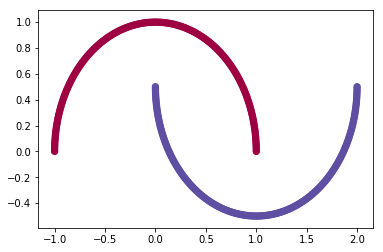

In [584]:

# DATA FOR CLASSIFICATION
# X, y = make_blobs(n_samples=400, centers=2, n_features=2, cluster_std=0.1,random_state=0)
X, y = make_moons(n_samples=400, shuffle=True, noise=None,random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

reshaped_y = np.array(y).reshape(len(y),1)

enc = OneHotEncoder()
enc.fit(reshaped_y)
encoded_y = enc.transform(reshaped_y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.33, random_state=42)
# --------------------------
print(X_train[0])

In [585]:
new_Net  = NeuralNet(3, 3, CrossEntropy)

input_layer = InputLayer(input_size=2)
first_layer = Layer(ReLU, out_size=3)
second_layer = Layer(Sigmoid, out_size=3)
out_layer = Layer(SoftMax, out_size=2)

input_to_first_connection = Connection(input_layer, 3, 3)
first_layer.add_connection(input_to_first_connection)

first_to_second_connection = Connection(first_layer, 3, 3)
second_layer.add_connection(first_to_second_connection)

second_to_third_connection = Connection(second_layer, 3, 3)
out_layer.add_connection(second_to_third_connection)


new_Net.add_layer(input_layer)
new_Net.add_layer(first_layer)
new_Net.add_layer(second_layer)
new_Net.add_layer(out_layer)

In [586]:
errors = [99999]
m_s = 4
for i in range(len(X_train)):
    randoms = np.random.randint(low=0, high=len(X_train), size=(4,))
#     print(randoms)
#     print(X_train[i:i+4])
#     print(X_train[randoms])
    res = net.feed_forward(X_train[randoms])
    error = net.backpropagate(y_train[randoms].T, res)
    errors.append(error)
    if i % 10 == 0:
        print("ERROR" + str(error))
    if(errors[-1] < 0.0001):
        break

print(errors[-1])
   


    


ERROR0.2920578530454725
ERROR0.2534353706346869
ERROR1.49817440321437
ERROR20.75436075099533
ERROR10.394685992481774
ERROR31.096573706610904
ERROR31.08531313535128
ERROR10.5284531356067
ERROR31.084016634659882
ERROR11.028840844469702
ERROR20.72226639938597
ERROR23.046387507433746
ERROR20.722266335740866
ERROR10.365670281734799
ERROR21.519718177226878
ERROR31.084080710021578
ERROR41.444532673226654
ERROR10.373605489132323
ERROR20.722266337481003
ERROR41.444532673226654
ERROR10.362803068782528
ERROR20.72229873796572
ERROR31.083399504430695
ERROR10.36113316732729
ERROR20.722266335645998
ERROR31.0833997160317
ERROR10.373453194688842
0.00013121216670328967


In [587]:
predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
targets = np.array([[0,0,0,1],
                  [0,0,0,1]])
ans = 0.71355817782  #Correct answer
x = CrossEntropy.calc(targets, predictions)
print(x)

0.7135581752992395


In [588]:
input = np.array([[0.1, 0.2, 0.7]])
print(input.shape)
res = new_Net.feed_forward(input)
output = np.array([[1.0, 0., 0.]])
to_check = np.array([[0.2698, 0.3223, 0.4078]])
new_Net.backpropagate(output.T, res)

(1, 3)


ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [589]:
net.train(X_train, y_train, 1000, minibatch_size=5)

Epoch: 0; Error: 41.4479369669623
Epoch: 1; Error: 31.11486720378074
Epoch: 2; Error: 31.083400663076695
Epoch: 3; Error: 21.121974929029868
Epoch: 4; Error: 20.727098644197508
Epoch: 5; Error: 31.08339985578944
Epoch: 6; Error: 41.71819060979453
Epoch: 7; Error: 41.44487017564016
Epoch: 8; Error: 41.49563112016173
Epoch: 9; Error: 41.444532776090796
Epoch: 10; Error: 41.90356475846078
Epoch: 11; Error: 31.083399681037285
Epoch: 12; Error: 41.44453272128908
Epoch: 13; Error: 10.363902747835347
Epoch: 14; Error: 11.508572716170509
Epoch: 15; Error: 20.722284119983584
Epoch: 16; Error: 31.50695923199575
Epoch: 17; Error: 20.72271090587629
Epoch: 18; Error: 41.44453267379576
Epoch: 19; Error: 21.840091421439443
Epoch: 20; Error: 42.05660727743508
Epoch: 21; Error: 41.51642579447707
Epoch: 22; Error: 10.361133166555542
Epoch: 23; Error: 31.083432228062197
Epoch: 24; Error: 41.609884372128455
Epoch: 25; Error: 31.171487788226948
Epoch: 26; Error: 20.723312341421874
Epoch: 27; Error: 10.3683

Epoch: 221; Error: 31.083399503920987
Epoch: 222; Error: 41.44453267295903
Epoch: 223; Error: 10.361134519956696
Epoch: 224; Error: 41.44453267272715
Epoch: 225; Error: 10.379647927343306
Epoch: 226; Error: 20.722782491958135
Epoch: 227; Error: 10.36695917288839
Epoch: 228; Error: 10.361773436873017
Epoch: 229; Error: 31.083423740364523
Epoch: 230; Error: 31.354328369534585
Epoch: 231; Error: 41.44453387565764
Epoch: 232; Error: 41.44453267376623
Epoch: 233; Error: 31.106915196921804
Epoch: 234; Error: 20.87897983955252
Epoch: 235; Error: 20.817008407474187
Epoch: 236; Error: 20.742964884958955
Epoch: 237; Error: 41.44453267668881
Epoch: 238; Error: 20.800193143439586
Epoch: 239; Error: 20.77374615653405
Epoch: 240; Error: 32.09742477958367
Epoch: 241; Error: 41.444532680751585
Epoch: 242; Error: 20.722302725466207
Epoch: 243; Error: 41.44453267401882
Epoch: 244; Error: 20.72238254726725
Epoch: 245; Error: 31.08341092145501
Epoch: 246; Error: 10.438674697858012
Epoch: 247; Error: 31.19

Epoch: 438; Error: 10.361133336507178
Epoch: 439; Error: 0.0026578790988184015
Epoch: 440; Error: 31.083399527367284
Epoch: 441; Error: 10.361133166308665
Epoch: 442; Error: 10.361133166308667
Epoch: 443; Error: 10.365948748498875
Epoch: 444; Error: 10.361133166308665
Epoch: 445; Error: 20.722266335114828
Epoch: 446; Error: 10.36113927929245
Epoch: 447; Error: 10.361155278762046
Epoch: 448; Error: 20.722266335114828
Epoch: 449; Error: 10.361305808013396
Epoch: 450; Error: 10.36790851996451
Epoch: 451; Error: 0.3267620475892005
Epoch: 452; Error: 6.358403252777392e-07
Epoch: 453; Error: 10.361133166476339
Epoch: 454; Error: 20.722266335114828
Epoch: 455; Error: 41.44453267272715
Epoch: 456; Error: 0.15659468430950965
Epoch: 457; Error: 20.87988828749211
Epoch: 458; Error: 20.722266335114828
Epoch: 459; Error: 10.361133166308665
Epoch: 460; Error: 10.361134823216245
Epoch: 461; Error: 20.72228415548384
Epoch: 462; Error: -2.0102915988539576e-09
Epoch: 463; Error: 31.083399503920994
Epoch

Epoch: 650; Error: 10.361160679135779
Epoch: 651; Error: 10.361133166308665
Epoch: 652; Error: 20.722266335114824
Epoch: 653; Error: -8.379259485035343e-10
Epoch: 654; Error: 20.72226633511483
Epoch: 655; Error: 41.44453267272715
Epoch: 656; Error: 10.361133166308665
Epoch: 657; Error: 20.722270492638895
Epoch: 658; Error: 10.514984066513575
Epoch: 659; Error: -2.4974999833519708e-09
Epoch: 660; Error: 10.361133403402915
Epoch: 661; Error: 9.40066900610169e-06
Epoch: 662; Error: 20.722266362611393
Epoch: 663; Error: 20.72336919948791
Epoch: 664; Error: 10.361135058371769
Epoch: 665; Error: 10.361133166308663
Epoch: 666; Error: 10.361133166308665
Epoch: 667; Error: 10.361133166308667
Epoch: 668; Error: 20.76811304803732
Epoch: 669; Error: 20.722266335114828
Epoch: 670; Error: 0.004561563205983627
Epoch: 671; Error: 32.01039595724057
Epoch: 672; Error: 10.361213900440243
Epoch: 673; Error: 10.361133166308667
Epoch: 674; Error: 20.94253874697801
Epoch: 675; Error: 31.374802688609453
Epoch

Epoch: 864; Error: 20.72226633511483
Epoch: 865; Error: 31.083399503920994
Epoch: 866; Error: 41.444532672727156
Epoch: 867; Error: 31.08339950392099
Epoch: 868; Error: 41.444532672727156
Epoch: 869; Error: 20.722266335114828
Epoch: 870; Error: 31.083399503920994
Epoch: 871; Error: 41.444532672727156
Epoch: 872; Error: 41.44453267272715
Epoch: 873; Error: 51.80566584153332
Epoch: 874; Error: 41.444532672727156
Epoch: 875; Error: 31.08339950392099
Epoch: 876; Error: 20.722266335114828
Epoch: 877; Error: 41.444532672727156
Epoch: 878; Error: 51.80566584153332
Epoch: 879; Error: 31.083399503920994
Epoch: 880; Error: 41.44453267272715
Epoch: 881; Error: 31.08339950392099
Epoch: 882; Error: 51.80566584153332
Epoch: 883; Error: 41.444532672727156
Epoch: 884; Error: 41.444532672727156
Epoch: 885; Error: 20.722266335114828
Epoch: 886; Error: 20.722266335114828
Epoch: 887; Error: 20.722266335114828
Epoch: 888; Error: 31.08339950392099
Epoch: 889; Error: 41.444532672727156
Epoch: 890; Error: 31.